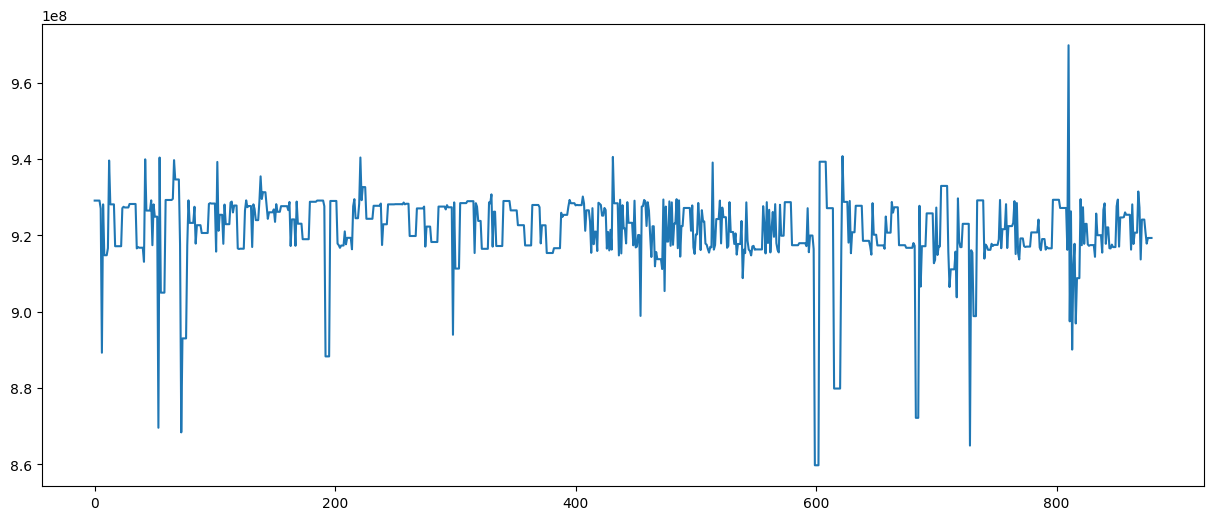

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=100)
dataset = pd.read_csv(r'D:\git\UECE-RNP-PMon2022\tratados\bbr esmond data_sem_outliers 10-18-2022.csv', usecols=[0], engine='python')
plt.plot(dataset)
plt.show()

In [25]:
# Set random seed to get the same result after each time running the code
tf.random.set_seed(7)

In [26]:
file = 'bbr esmond data 08-25-2022.csv'
df = pd.read_csv(r'D:\git\UECE-RNP-PMon2022\tratados\bbr esmond data_sem_outliers 10-18-2022.csv', usecols=[0], engine='python')

In [27]:
#normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

In [28]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (15, 6), dpi=100)
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 

In [29]:
# Split train data and test data
train_size = int(len(df)*0.7)

# train_data = df.WC.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = df[:train_size]
test_data = df[train_size:]

In [30]:
# Scale data
# The input to scaler.fit -> array-like, sparse matrix, dataframe of shape (n_samples, n_features)
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [31]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train_scaled,30)
X_test, y_test = create_dataset(test_scaled,30)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)
X_test[:33].shape

X_train.shape:  (586, 30, 1)
y_train.shape:  (586, 1)
X_test.shape:  (234, 30, 1)
y_test.shape:  (234, 1)


(33, 30, 1)

In [32]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer 
    model.add(GRU(units = units, return_sequences = True, 
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
   
    return model
model_gru = create_gru(64)

# Create LSTM model
def create_lstm(units):
    model = Sequential()
    # Input layer
    model.add(LSTM(units = units, return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    # Hidden layer
    model.add(LSTM(units = units))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    
    return model
model_lstm = create_lstm(64)

def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 200, validation_split = 0.2,
                    batch_size = 26, shuffle = False)
    return history

history_gru = fit_model(model_gru)
history_lstm = fit_model(model_lstm)

Epoch 1/200
18/18 [==============================] - 2s 30ms/step - loss: 0.1252 - val_loss: 0.0299
Epoch 2/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0215 - val_loss: 0.0331
Epoch 3/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0173 - val_loss: 0.0274
Epoch 4/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0140 - val_loss: 0.0274
Epoch 5/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0152 - val_loss: 0.0271
Epoch 6/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0142 - val_loss: 0.0270
Epoch 7/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0138 - val_loss: 0.0265
Epoch 8/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0157 - val_loss: 0.0262
Epoch 9/200
18/18 [==============================] - 0s 10ms/step - loss: 0.0129 - val_loss: 0.0262
Epoch 10/200
18/18 [==============================] - 0s 9ms/step - loss: 0.0128 - val_loss: 0.0257
Epoch 1

8/8 [==============================] - 0s 3ms/step
GRU:
Mean Absolute Error: 0.0490
Root Mean Square Error: 0.0846

LSTM:
Mean Absolute Error: 0.0495
Root Mean Square Error: 0.0869



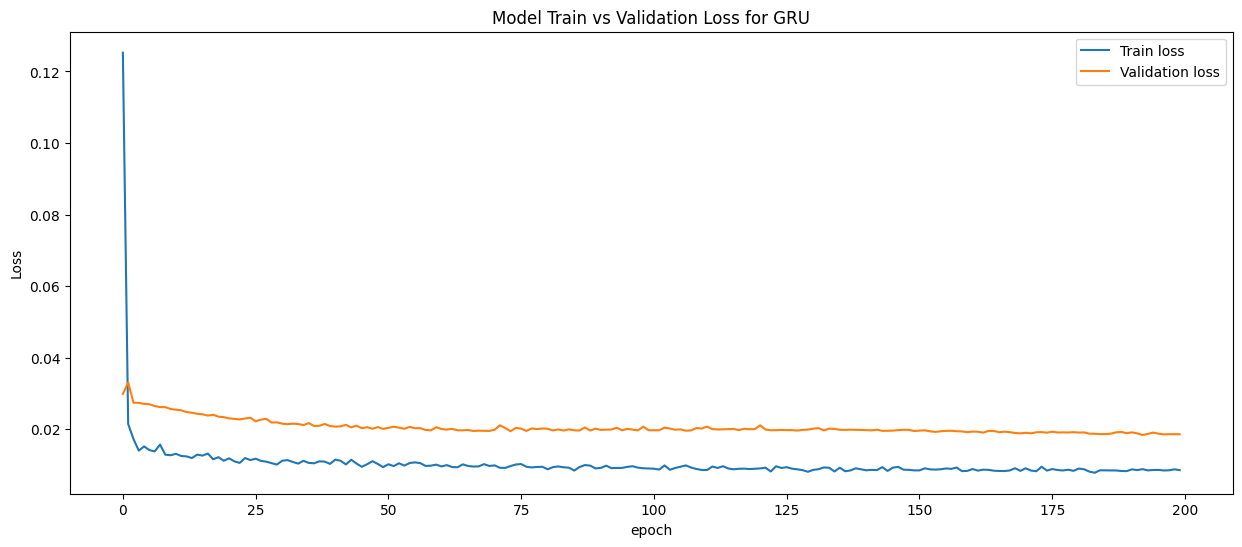

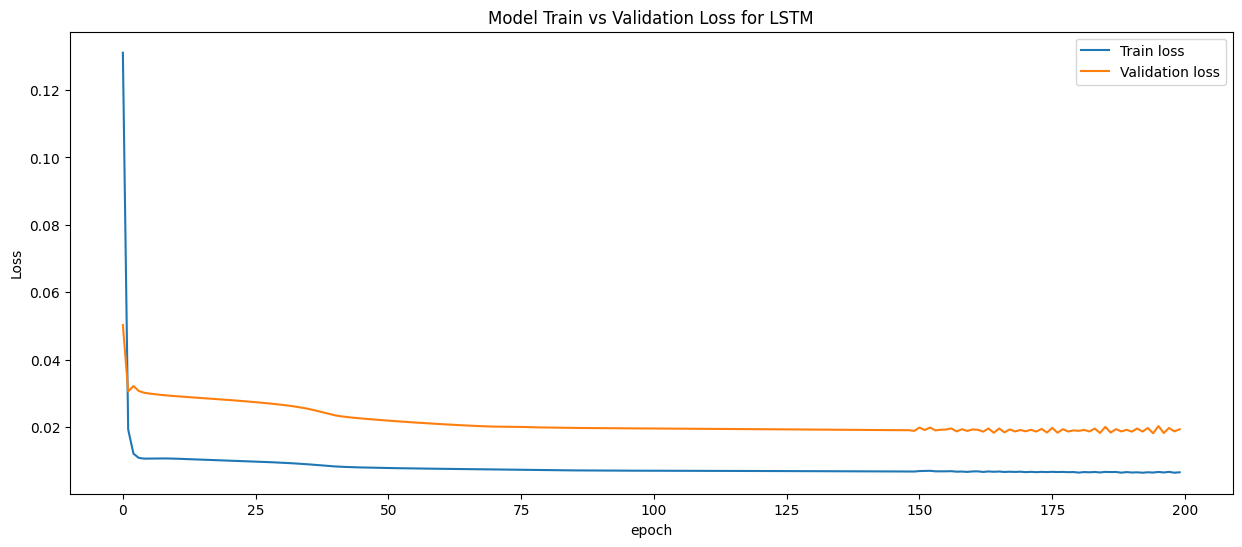

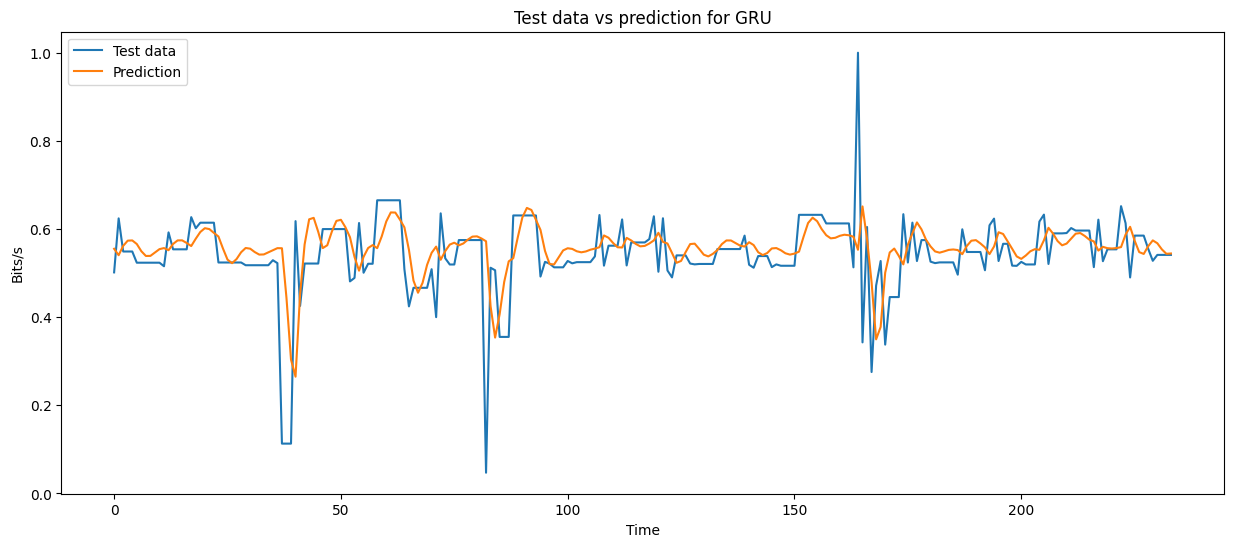

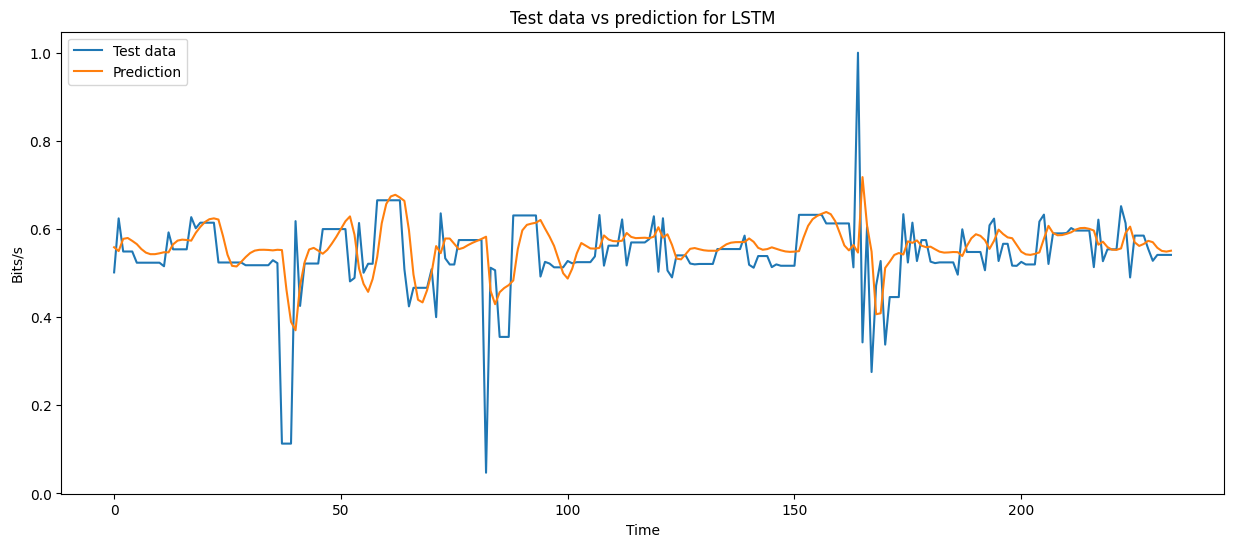

In [33]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (15, 6), dpi=100)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history_gru, 'GRU')
plot_loss (history_lstm, 'LSTM')

# Transform data back to original data space
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_gru = prediction(model_gru)
prediction_lstm = prediction(model_lstm)

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(15, 6), dpi=100)
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction), label='Prediction')
    

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Bits/s')

plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_lstm, 'LSTM', y_test)

# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
    #plt.bar(mae)
    #plt.bar(rmse)

evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')


In [34]:
X_test.shape

(234, 30, 1)

In [35]:
y_test.shape

(234, 1)

In [36]:
df.shape

(880, 1)

In [37]:
test_data.shape

(264, 1)

In [38]:
prediction_gru.shape

(234, 1)